### Introduction to Classification and K-Nearest Neighbors

**Objectives**

- Identify *Classification* problems in supervised learning
- Use `KNeighborsClassifier` to model classification problems using scikitlearn
- Use `StandardScaler` to prepare data for KNN models
- Use `Pipeline` to combine the preprocessing
- Use `KNNImputer` to impute missing values


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.datasets import make_blobs
from sklearn import set_config
set_config('display')

### A Second Regression Model

In [2]:
#creating synthetic dataset
x = np.linspace(0, 5, 100)
y = 3*x + 4 + np.random.normal(scale = 3, size = len(x))
df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0.000000,6.655411
1,0.050505,2.559788
2,0.101010,6.612226
3,0.151515,0.010838
4,0.202020,9.766093


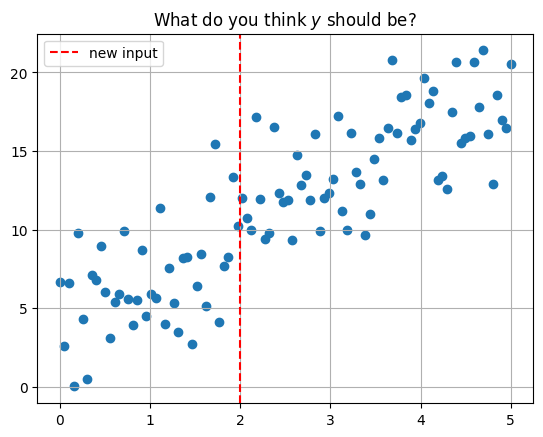

In [3]:
#plot data and new observation
plt.scatter(x, y)
plt.axvline(2, color='red', linestyle = '--', label = 'new input')
plt.grid()
plt.legend()
plt.title(r'What do you think $y$ should be?');

### KNearest Neighbors

Predict the average of the $k$ nearest neighbors.  One way to think about "nearest" is euclidean distance.  We can determine the distance between each data point and the new data point at $x = 2$ with `np.linalg.norm`.  This is a more general way of determining the euclidean distance between vectors. 

In [4]:
#compute distance from each point 
#to new observation
df['distance from x = 2'] = np.linalg.norm(df[['x']] - 2, axis = 1)
df.head()

,x,y,distance from x = 2
0,0.000000,6.655411,2.000000
1,0.050505,2.559788,1.949495
2,0.101010,6.612226,1.898990
3,0.151515,0.010838,1.848485
4,0.202020,9.766093,1.797980


In [5]:
#five nearest points
df.nsmallest(5, 'distance from x = 2')

,x,y,distance from x = 2
40,2.020202,11.995544,0.020202
39,1.969697,10.239016,0.030303
41,2.070707,10.760633,0.070707
38,1.919192,13.334415,0.080808
42,2.121212,9.990752,0.121212


In [6]:
#average of five nearest points
df.nsmallest(5, 'distance from x = 2')['y'].mean()

11.264072017167532

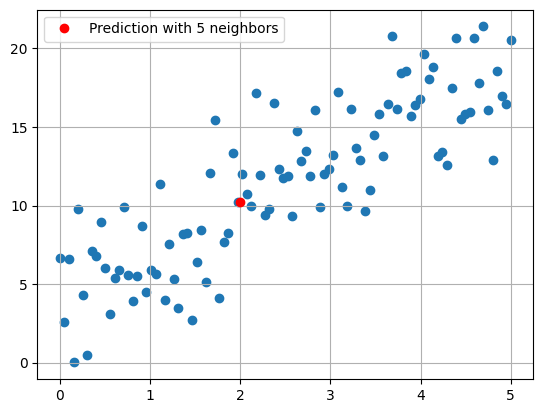

In [7]:
#predicted value with 5 neighbors
plt.scatter(x, y)
plt.plot(2, 10.207196799, 'ro', label = 'Prediction with 5 neighbors')
plt.grid()
plt.legend();

#### Using `sklearn`

The `KNeighborsRegressor` estimator can be used to build the KNN model.  

In [8]:
from sklearn.neighbors import KNeighborsRegressor

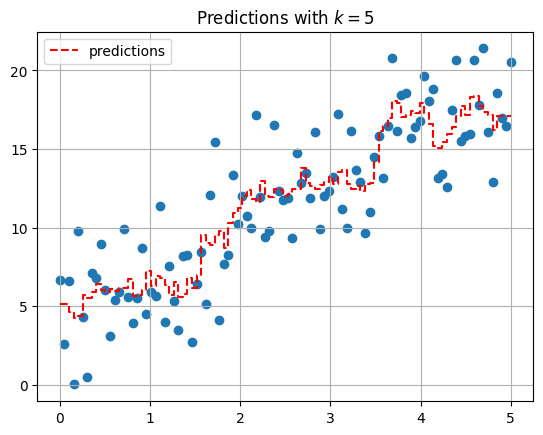

In [9]:
#predict for all data
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(x.reshape(-1, 1), y)
predictions = knn.predict(x.reshape(-1, 1))
plt.scatter(x, y)
plt.step(x, predictions, '--r', label = 'predictions')
plt.grid()
plt.legend()
plt.title(r'Predictions with $k = 5$');

In [10]:
from ipywidgets import interact 
import ipywidgets as widgets

ModuleNotFoundError: No module named 'ipywidgets'

In [ ]:
def knn_explorer(n_neighbors):
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(x.reshape(-1, 1), y)
    predictions = knn.predict(x.reshape(-1, 1))
    plt.scatter(x, y)
    plt.step(x, predictions, '--r', label = 'predictions')
    plt.grid()
    plt.legend()
    plt.title(f'Predictions with $k = {n_neighbors}$');

In [ ]:
#explore how predictions change as you change k
interact(knn_explorer, n_neighbors = widgets.IntSlider(value = 1, 
                                                       low = 1, 
                                                       high = len(x)));

### Classification

Unlike regression, classification problems involve predicting a categorical variable.  For example, the breed of dog, whether or not a customer purchases an item, the presence of a disease, and so on.  Today, we will examine the examples of predicting whether or not a person survived the titanic sinking and whether or not a person defaults on their credit card.  For each of these problems, we will use the K-Nearest Neighbors algorithm, which we introduce below.

#### Problem Motivation

In [ ]:
#make data
X, y = make_blobs(centers = 2, cluster_std=2, random_state = 42)

In [ ]:
#create dataframe
data_1 = pd.DataFrame(X, columns = ['X1', 'X2'])
data_1['y'] = y

In [ ]:
#plot sample dataset
sns.scatterplot(data = data_1, x = 'X1', y = 'X2', hue = 'y')
plt.title('Sample Classification Data')
plt.grid();

In [ ]:
#dataset with new point
sns.scatterplot(data = data_1, x = 'X1', y = 'X2', hue = 'y')
plt.title('Sample Classification Data')
plt.plot(3, 4, 'ro', markersize = 10, label = 'New Data')
plt.legend()
plt.grid();

#### The Intuition

KNN relies on the idea of distance and classifying new datapoints based on the new datapoints distance from known data.  There is no equation to be learned as we had with linear regression so we call this a *non-parametric* model.  Essentially, we decide how many points we want to use for voting on the nearness.  Below, we demonstrate this with a small sample of the `titanic` data.

In [11]:
titanic = sns.load_dataset('titanic')

In [12]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [13]:
sample_train = titanic[['pclass', 'age', 'survived']].head()
sample_train

,pclass,age,survived
0,3,22.0,0
1,1,38.0,1
2,3,26.0,1
3,1,35.0,1
4,3,35.0,0


In [14]:
new_data = titanic[['pclass', 'age']].iloc[30]

In [15]:
new_data

pclass     1.0
age       40.0
Name: 30, dtype: float64

In [16]:
np.linalg.norm(sample_train.iloc[0, :2] - new_data)

18.110770276274835

In [17]:
distances = sample_train[['pclass', 'age']].apply(lambda x: np.linalg.norm(x - new_data), axis = 1)
distances

0    18.110770
1     2.000000
2    14.142136
3     5.000000
4     5.385165
dtype: float64

In [18]:
sample_train['distance'] = distances

In [19]:
sample_train

,pclass,age,survived,distance
0,3,22.0,0,18.110770
1,1,38.0,1,2.000000
2,3,26.0,1,14.142136
3,1,35.0,1,5.000000
4,3,35.0,0,5.385165


In [20]:
sample_train.sort_values('distance')

,pclass,age,survived,distance
1,1,38.0,1,2.000000
3,1,35.0,1,5.000000
4,3,35.0,0,5.385165
2,3,26.0,1,14.142136
0,3,22.0,0,18.110770


#### Question

If you determine the outcome based on the 1 nearest neighbor, what would you predict? 3 nearest neighbors?

In [21]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


### Using `KNeighborsClassifier`

The `KNeighborsClassifier` works just like the earlier `LinearRegression` estimator.  You will instantiate, fit, predict, and score the model as before.  Additionally, we have a parameter `n_neighbors` that will control how many neighbors we make our classification by.  To begin, let us form our training and testing data using `pclass` and `age` with 5 neighbors.

In [22]:
# X and y
titanic = titanic.dropna()
X = titanic[['pclass', 'age']]
y = titanic['survived']

In [23]:
# train/test split
# random_state = 22
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [24]:
# instantiate
knn = KNeighborsClassifier(n_neighbors=5)

In [25]:
# fit
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [26]:
# score
knn.score(X_train, y_train)

0.7720588235294118

In [27]:
knn.score(X_test, y_test)

0.6739130434782609

#### `.score`

Here, we score the model using the total percent correct or **accuracy**.  Later, we will explore additional metrics for classification but for now this is an intuitive way to score a classifier.  

$$\text{accuracy} = \frac{\text{number correct}}{\text{number total}}$$



### Comparing to Baseline

Typically, you will use the majority class to serve as a baseline predictor.  Here, assume you predict just guessing what the majority class is.  For this example, it is easy to use the `.value_counts(normalize = True)` to create a baseline accuracy.

In [ ]:
X_train.head()

In [ ]:
#baseline
y_train.value_counts(normalize = True)

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
#which was better?
dummy = DummyClassifier().fit(X_train, y_train)
dummy.score(X_train, y_train)

**PROBLEM**

Use `KNeighborsClassifier` to predict the `default` column using `balance` and `income`.  Create a train/test split and report the score on both train and test data.

In [ ]:
default = pd.read_csv('https://raw.githubusercontent.com/jfkoehler/nyu_bootcamp_fa23/main/data/Default.csv', index_col = 0)
default.head()

In [ ]:
X = default[['balance', 'income']]
y = default['default']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [ ]:
knn = KNeighborsClassifier().fit(X_train, y_train)

In [ ]:
knn.score(X_train, y_train)

In [ ]:
knn.score(X_test, y_test)

In [ ]:
y_train.value_counts(normalize = True)

### Improving the Model

Now, we can try two things to improve our model.  First, is to change the data we are using and incorporate more features into the model.  To do so, we may want to encode categorical features and use these to feed into the model.  To do so, we again will use `make_column_transformer` and select the categorical features to one-hot-encode, while passing the other features through.

In [ ]:
titanic.head(2)

In [ ]:
cat_cols = ['sex', 'embarked', 'class', 'adult_male', 'alone']
num_cols = ['pclass', 'age', 'fare']
#select columns
X = titanic.loc[:, cat_cols + num_cols]
y = titanic['survived']

In [ ]:
#create OHE
ohe = OneHotEncoder(sparse = False, drop = 'if_binary')

In [ ]:
#transformer
encoder = make_column_transformer((ohe, cat_cols), 
                                  verbose_feature_names_out=False,
                                  remainder='passthrough')

In [ ]:
# train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [ ]:
# fit and transform train
X_train_encoded = encoder.fit_transform(X_train)

In [ ]:
encoder.get_feature_names_out()

In [ ]:
# transform the test
X_test_encoded = encoder.transform(X_test)

In [ ]:
# instantiate the KNN estimator
knn = KNeighborsClassifier(n_neighbors=1)

In [ ]:
# fit on train
knn.fit(X_train_encoded, y_train)

In [ ]:
# score on test
knn.score(X_test_encoded, y_test)

In [ ]:
y_train.value_counts(normalize = True)

### Another Important Transformation

In addition to using the `OneHotEncoder` to encode the categorical features, existing numeric features need to be put on the same scale.  To do this, we convert the data to $z$-scores, computed by:

$$z = \frac{x_i - \mu}{\sigma}$$

You can accomplish this transformation using the `StandardScaler`.  One way to streamline this is to replace the `passthrough` argument in the `make_column_transformer`.

In [ ]:
# transformer for scaling
encoder = make_column_transformer((ohe, cat_cols), remainder=StandardScaler())

In [ ]:
# fit and transform
X_train_encoded = encoder.fit_transform(X_train)
# transform
X_test_encoded = encoder.transform(X_test)

In [ ]:
# instantiate and fit
knn = KNeighborsClassifier().fit(X_train_encoded, y_train)

In [ ]:
# score train and test
print(knn.score(X_train_encoded, y_train))
print(knn.score(X_test_encoded, y_test))

### Streamlining data preparation and modeling with `Pipeine`

The `Pipeline` object allows you to chain together different transformers and estimator objects from scikitlearn.  In our example, this involves first using the `make_column_transformer` and then to `KNearestNeighbor` classifier.  See the user guide [here](https://scikit-learn.org/stable/modules/compose.html#pipeline-chaining-estimators) for more examples.

In [ ]:
# create a Pipeline
pipe = Pipeline([('encode', encoder), ('knn', knn)])

In [ ]:
# fit the train data
pipe.fit(X_train, y_train)

In [ ]:
# score the train and test
pipe.score(X_train, y_train)

**PROBLEM**

Revisit the `default` problem and use a pipeline to transform the `student` column.  Score your model on train and test data.

#### Other Uses of KNN

Another place the `KNeighborsClassifier` can be used is to impute missing data.  Here, we use the nearest datapoints to fill in missing values.  Scikitlearn has a `KNNImputer` that will fill in missing values based on the average of $n$ neighbors averages.  

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
titanic = sns.load_dataset('titanic')
titanic.info()

In [ ]:
# instantiate


In [ ]:
# fit and transform


In [ ]:
# encoder


In [ ]:
# pipeline


In [ ]:
# fit on train


In [ ]:
# score on train and test


#### Selecting the right `k`


In [ ]:
# loop over different neighbor options
# fitting estimators to each
# and tracking the train/test scores


#### `GridSearchCV`

- A dictionary of parameters
- An estimator or pipeline


#### Summary

While the KNN model is easy to understand and implement, there are many other classification algorithms that frequently will perform better and contain interpretable parameters.  Next class, we will examine one such example with `LogisticRegression` and the following week we will examine tree models and ensembles.